### TEXT PREPROCESSING

In [1]:
import nltk
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from ast import literal_eval
import re, string
import pandas as pd

In [2]:
df =  pd.read_csv("dataset_en.txt")
tweets = df['tweet'].tolist()

In [3]:
def preprocess_word(w):
    # Removes punctuation
    
    translator = str.maketrans('', '', string.punctuation)
    punctuation = w.translate(translator)

    return punctuation

In [4]:
def preprocessing(x):
    # Returns a nested list of the processed sentences
    
    # Removes mentions, numbers and links
    mentions = [re.sub(r'@\w+',"", sent) for sent in tweets]
    numbers = [re.sub('[0-9]+', "", sent) for sent in mentions]
    links = [re.sub(r'http\S+', "", sent) for sent in numbers]
    
    # Removes stopwords
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in links if not w.lower() in stop_words]
    
    # Removes lower text, word tokenization
    lower = [[sent.lower()] for sent in filtered_sentence]
    in_list = [word for sent in lower for word in sent]
    word_tokenized = [word_tokenize(sent) for sent in in_list]
    word_tokenized = [sent for sent in word_tokenized if sent]
    
    for _id, sent in enumerate(word_tokenized):
        word_tokenized[_id] =  [preprocess_word(w) for w in sent]
    
    # Removes empty elements, sentences and retweets
    words = [[word for word in sent if word != '' and word != 'rt' and len(word)>1] for sent in word_tokenized]
    sentences = [sent for sent in words if sent]

    return sentences

In [5]:
text = preprocessing(tweets)
print(text)

[['as', 'woman', 'you', 'should', 'nt', 'complain', 'about', 'cleaning', 'up', 'your', 'house', 'amp', 'as', 'man', 'you', 'should', 'always', 'take', 'the', 'trash', 'out'], ['boy', 'dats', 'cold', 'tyga', 'dwn', 'bad', 'for', 'cuffin', 'dat', 'hoe', 'in', 'the', 'st', 'place'], ['dawg', 'you', 'ever', 'fuck', 'bitch', 'and', 'she', 'start', 'to', 'cry', 'you', 'be', 'confused', 'as', 'shit'], ['she', 'look', 'like', 'tranny'], ['the', 'shit', 'you', 'hear', 'about', 'me', 'might', 'be', 'true', 'or', 'it', 'might', 'be', 'faker', 'than', 'the', 'bitch', 'who', 'told', 'it', 'to', 'ya'], ['the', 'shit', 'just', 'blows', 'me', 'claim', 'you', 'so', 'faithful', 'and', 'down', 'for', 'somebody', 'but', 'still', 'fucking', 'with', 'hoes'], ['can', 'not', 'just', 'sit', 'up', 'and', 'hate', 'on', 'another', 'bitch', 'got', 'too', 'much', 'shit', 'going', 'on'], ['cause', 'tired', 'of', 'you', 'big', 'bitches', 'coming', 'for', 'us', 'skinny', 'girls'], ['amp', 'you', 'might', 'not', 'get',

### BAG OF WORDS 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from ast import literal_eval

try: 
    assert(literal_eval(str(text)) == text.copy())
except AssertionError:
    print('failed to convert')
    
final_str = ([" ".join(x) for x in text])

count_vect = CountVectorizer()
bow = count_vect.fit_transform(final_str).toarray()
print(bow)

[[1 0 0 ... 0 2 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 ...
 [0 1 0 ... 0 2 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [7]:
vocab = count_vect.get_feature_names()

In [8]:
#Returns the frequency of every word in total
sumindex = [sum(x) for x in zip(*bow)]

### TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
tfidf = count_vect.fit_transform(final_str).toarray()
print(tfidf)

[[1 0 0 ... 0 2 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 ...
 [0 1 0 ... 0 2 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


### EMBEDDINGS 

In [10]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np

model = Word2Vec(sentences=text, window=5, min_count=1, workers=4)
model.save("word2vec.model")

vector = model.wv['no'] #returns numpy vector of a word
sims = model.wv.most_similar('no', topn=10) #returns similar words

embeddings = [model.wv[word] for word in text]

C:\Users\Angelina\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Calculate the word vector average for every sentence:

In [11]:
v_average = []
for i in text:
    av = np.mean(model.wv[i], axis=0)
    v_average.append(av)

In [12]:
from sklearn.decomposition import IncrementalPCA  
from sklearn.manifold import TSNE                 
import numpy as np                                  


def reduce_dimensions(model):
    num_dimensions = 2 


    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key) 

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(autosize=True)
    plt.scatter(x_vals, y_vals)

    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)

### SYNTAX

In [13]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Masking

padded = pad_sequences(text, padding="post", truncating="post", maxlen=10, dtype=object)

In [14]:
print(padded)

[['as' 'woman' 'you' 'should' 'nt' 'complain' 'about' 'cleaning' 'up'
  'your']
 ['boy' 'dats' 'cold' 'tyga' 'dwn' 'bad' 'for' 'cuffin' 'dat' 'hoe']
 ['dawg' 'you' 'ever' 'fuck' 'bitch' 'and' 'she' 'start' 'to' 'cry']
 ['she' 'look' 'like' 'tranny' 0.0 0.0 0.0 0.0 0.0 0.0]
 ['the' 'shit' 'you' 'hear' 'about' 'me' 'might' 'be' 'true' 'or']
 ['the' 'shit' 'just' 'blows' 'me' 'claim' 'you' 'so' 'faithful' 'and']
 ['can' 'not' 'just' 'sit' 'up' 'and' 'hate' 'on' 'another' 'bitch']
 ['cause' 'tired' 'of' 'you' 'big' 'bitches' 'coming' 'for' 'us' 'skinny']
 ['amp' 'you' 'might' 'not' 'get' 'ya' 'bitch' 'back' 'amp' 'thats']
 ['hobbies' 'include' 'fighting' 'mariam' 'bitch' 0.0 0.0 0.0 0.0 0.0]
 ['keeks' 'is' 'bitch' 'she' 'curves' 'everyone' 'lol' 'walked' 'into'
  'conversation']
 ['murda' 'gang' 'bitch' 'its' 'gang' 'land' 0.0 0.0 0.0 0.0]
 ['so' 'hoes' 'that' 'smoke' 'are' 'losers' 'yea' 'go' 'on' 'ig']
 ['bad' 'bitches' 'is' 'the' 'only' 'thing' 'that' 'like' 0.0 0.0]
 ['bitch' 'get' 'up

In [15]:
print(type(padded))
print(type(padded[0]))
print(type(padded[0][0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'str'>


In [17]:
def to_string(x):

    sequences = [] 
    
    for sent in x:
        sentences = sent.tolist()
        sequences.append([str(word) for word in sentences])
        
    return sequences

sequences = to_string(padded)
print(sequences)

[['as', 'woman', 'you', 'should', 'nt', 'complain', 'about', 'cleaning', 'up', 'your'], ['boy', 'dats', 'cold', 'tyga', 'dwn', 'bad', 'for', 'cuffin', 'dat', 'hoe'], ['dawg', 'you', 'ever', 'fuck', 'bitch', 'and', 'she', 'start', 'to', 'cry'], ['she', 'look', 'like', 'tranny', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'], ['the', 'shit', 'you', 'hear', 'about', 'me', 'might', 'be', 'true', 'or'], ['the', 'shit', 'just', 'blows', 'me', 'claim', 'you', 'so', 'faithful', 'and'], ['can', 'not', 'just', 'sit', 'up', 'and', 'hate', 'on', 'another', 'bitch'], ['cause', 'tired', 'of', 'you', 'big', 'bitches', 'coming', 'for', 'us', 'skinny'], ['amp', 'you', 'might', 'not', 'get', 'ya', 'bitch', 'back', 'amp', 'thats'], ['hobbies', 'include', 'fighting', 'mariam', 'bitch', '0.0', '0.0', '0.0', '0.0', '0.0'], ['keeks', 'is', 'bitch', 'she', 'curves', 'everyone', 'lol', 'walked', 'into', 'conversation'], ['murda', 'gang', 'bitch', 'its', 'gang', 'land', '0.0', '0.0', '0.0', '0.0'], ['so', 'hoes', 't

In [18]:
def flatten_list(x):
#Takes a nested list and converts it into a list of elements
#where every sublist is a new element

    new_list = [] 
    
    for sent in x:
        sentences = " ".join(sent)
        new_list.append(sentences)
    
    return new_list

new = flatten_list(sequences)
print(new)

['as woman you should nt complain about cleaning up your', 'boy dats cold tyga dwn bad for cuffin dat hoe', 'dawg you ever fuck bitch and she start to cry', 'she look like tranny 0.0 0.0 0.0 0.0 0.0 0.0', 'the shit you hear about me might be true or', 'the shit just blows me claim you so faithful and', 'can not just sit up and hate on another bitch', 'cause tired of you big bitches coming for us skinny', 'amp you might not get ya bitch back amp thats', 'hobbies include fighting mariam bitch 0.0 0.0 0.0 0.0 0.0', 'keeks is bitch she curves everyone lol walked into conversation', 'murda gang bitch its gang land 0.0 0.0 0.0 0.0', 'so hoes that smoke are losers yea go on ig', 'bad bitches is the only thing that like 0.0 0.0', 'bitch get up off me 0.0 0.0 0.0 0.0 0.0', 'bitch nigga miss me with it 0.0 0.0 0.0 0.0', 'bitch plz whatever 0.0 0.0 0.0 0.0 0.0 0.0 0.0', 'bitch who do you love 0.0 0.0 0.0 0.0 0.0', 'black bottle amp bad bitch 0.0 0.0 0.0 0.0 0.0', 'broke bitch cant tell me nothing

In [19]:
import spacy

def dependency_parsing(x):
# Returns a nested list of syntactic label

    nlp = spacy.load("en_core_web_sm")
    dependencies = []
    for sent in x:
        doc = nlp(sent)
        new_list = [token.dep_ for token in doc]
        dependencies.append(new_list)
        
    return dependencies

dep = dependency_parsing(new)

In [20]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import string
import pprint
%matplotlib inline

In [21]:
#Append every word to a wordset
wordset = set()
for sentence in text:
    for word in sentence:
        wordset.add(word)

In [22]:
print(wordset)

{'about', 'is', 'bad', 'curves', 'blows', 'always', 'hate', 'that', 'another', 'coming', 'lol', 'how', 'would', 'keeks', 'sit', 'hennessy', 'dat', 'are', 'man', 'game', 'plz', 'bitter', 'cause', 'want', 'me', 'the', 'going', 'thats', 'cant', 'and', 'black', 'txt', 'nt', 'us', 'ya', 'tell', 'just', 'into', 'miss', 'st', 'mariam', 'cry', 'not', 'might', 'even', 're', 'toes', 'angry', 'wont', 'kermit', 'these', 'toeing', 'get', 'of', 'hobbies', 'out', 'new', 'smoke', 'bitches', 'if', 'my', 'only', 'met', 'faithful', 'fuck', 'on', 'bottle', 'for', 'be', 'lips', 'so', 'nino', 'murda', 'conversation', 'whatever', 'hitting', 'do', 'videos', 'ig', 'trash', 'ai', 'love', 'hardwood', 'cold', 'up', 'bird', 'hear', 'this', 'bitch', 'walked', 'hoe', 'to', 'losers', 'with', 'fighting', 'dwn', 'broke', 'place', 'who', 'your', 'old', 'pussy', 'app', 'still', 'ever', 'yea', 'business', 'wetter', 'she', 'what', 'her', 'shit', 'tranny', 'or', 'dats', 'fucking', 'start', 'ocean', 'like', 'dr', 'complain',

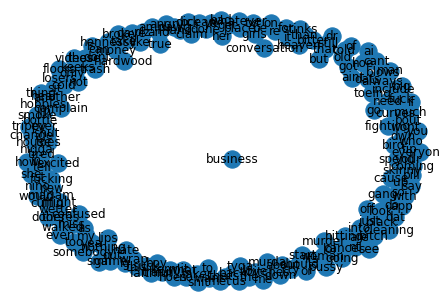

In [23]:
#Add every word as a node
base_graph = nx.Graph()
base_graph.add_nodes_from(wordset)
nx.draw(base_graph, with_labels=True)

In [71]:
rep = {}
processed_sentences = []
nlp = spacy.load("en_core_web_sm")

for sent_id, sent in enumerate(new):
    sentence_graph = base_graph.copy()
    processed_sentences.append(nlp(sent))

In [172]:
#Add edges between the nodes according to syntactic relations
for sent_id, sent in enumerate(processed_sentences):
    for token in sent:
        nodeA = token.text
        nodeB = token.head.text
        sentence_graph.add_edge(nodeA, nodeB)
        sentence_representation =  nx.adjacency_matrix(sentence_graph) #sparse matrix
        rep[sent_id] = sentence_representation.toarray()

In [216]:
#Flatten the sentence representation array
arr = []
for outer_list_id, outer_list in enumerate(rep.values()):
    arr.append([item for item in inner_list for inner_list in outer_list]) 

In [217]:
print('List:     ', type(arr), len(arr))
print('Sentence: ', type(arr[0]), len(arr[0]))
print('Item:     ', type(arr[0][0]))

List:      <class 'list'> 35
Sentence:  <class 'list'> 40000
Item:      <class 'numpy.intc'>


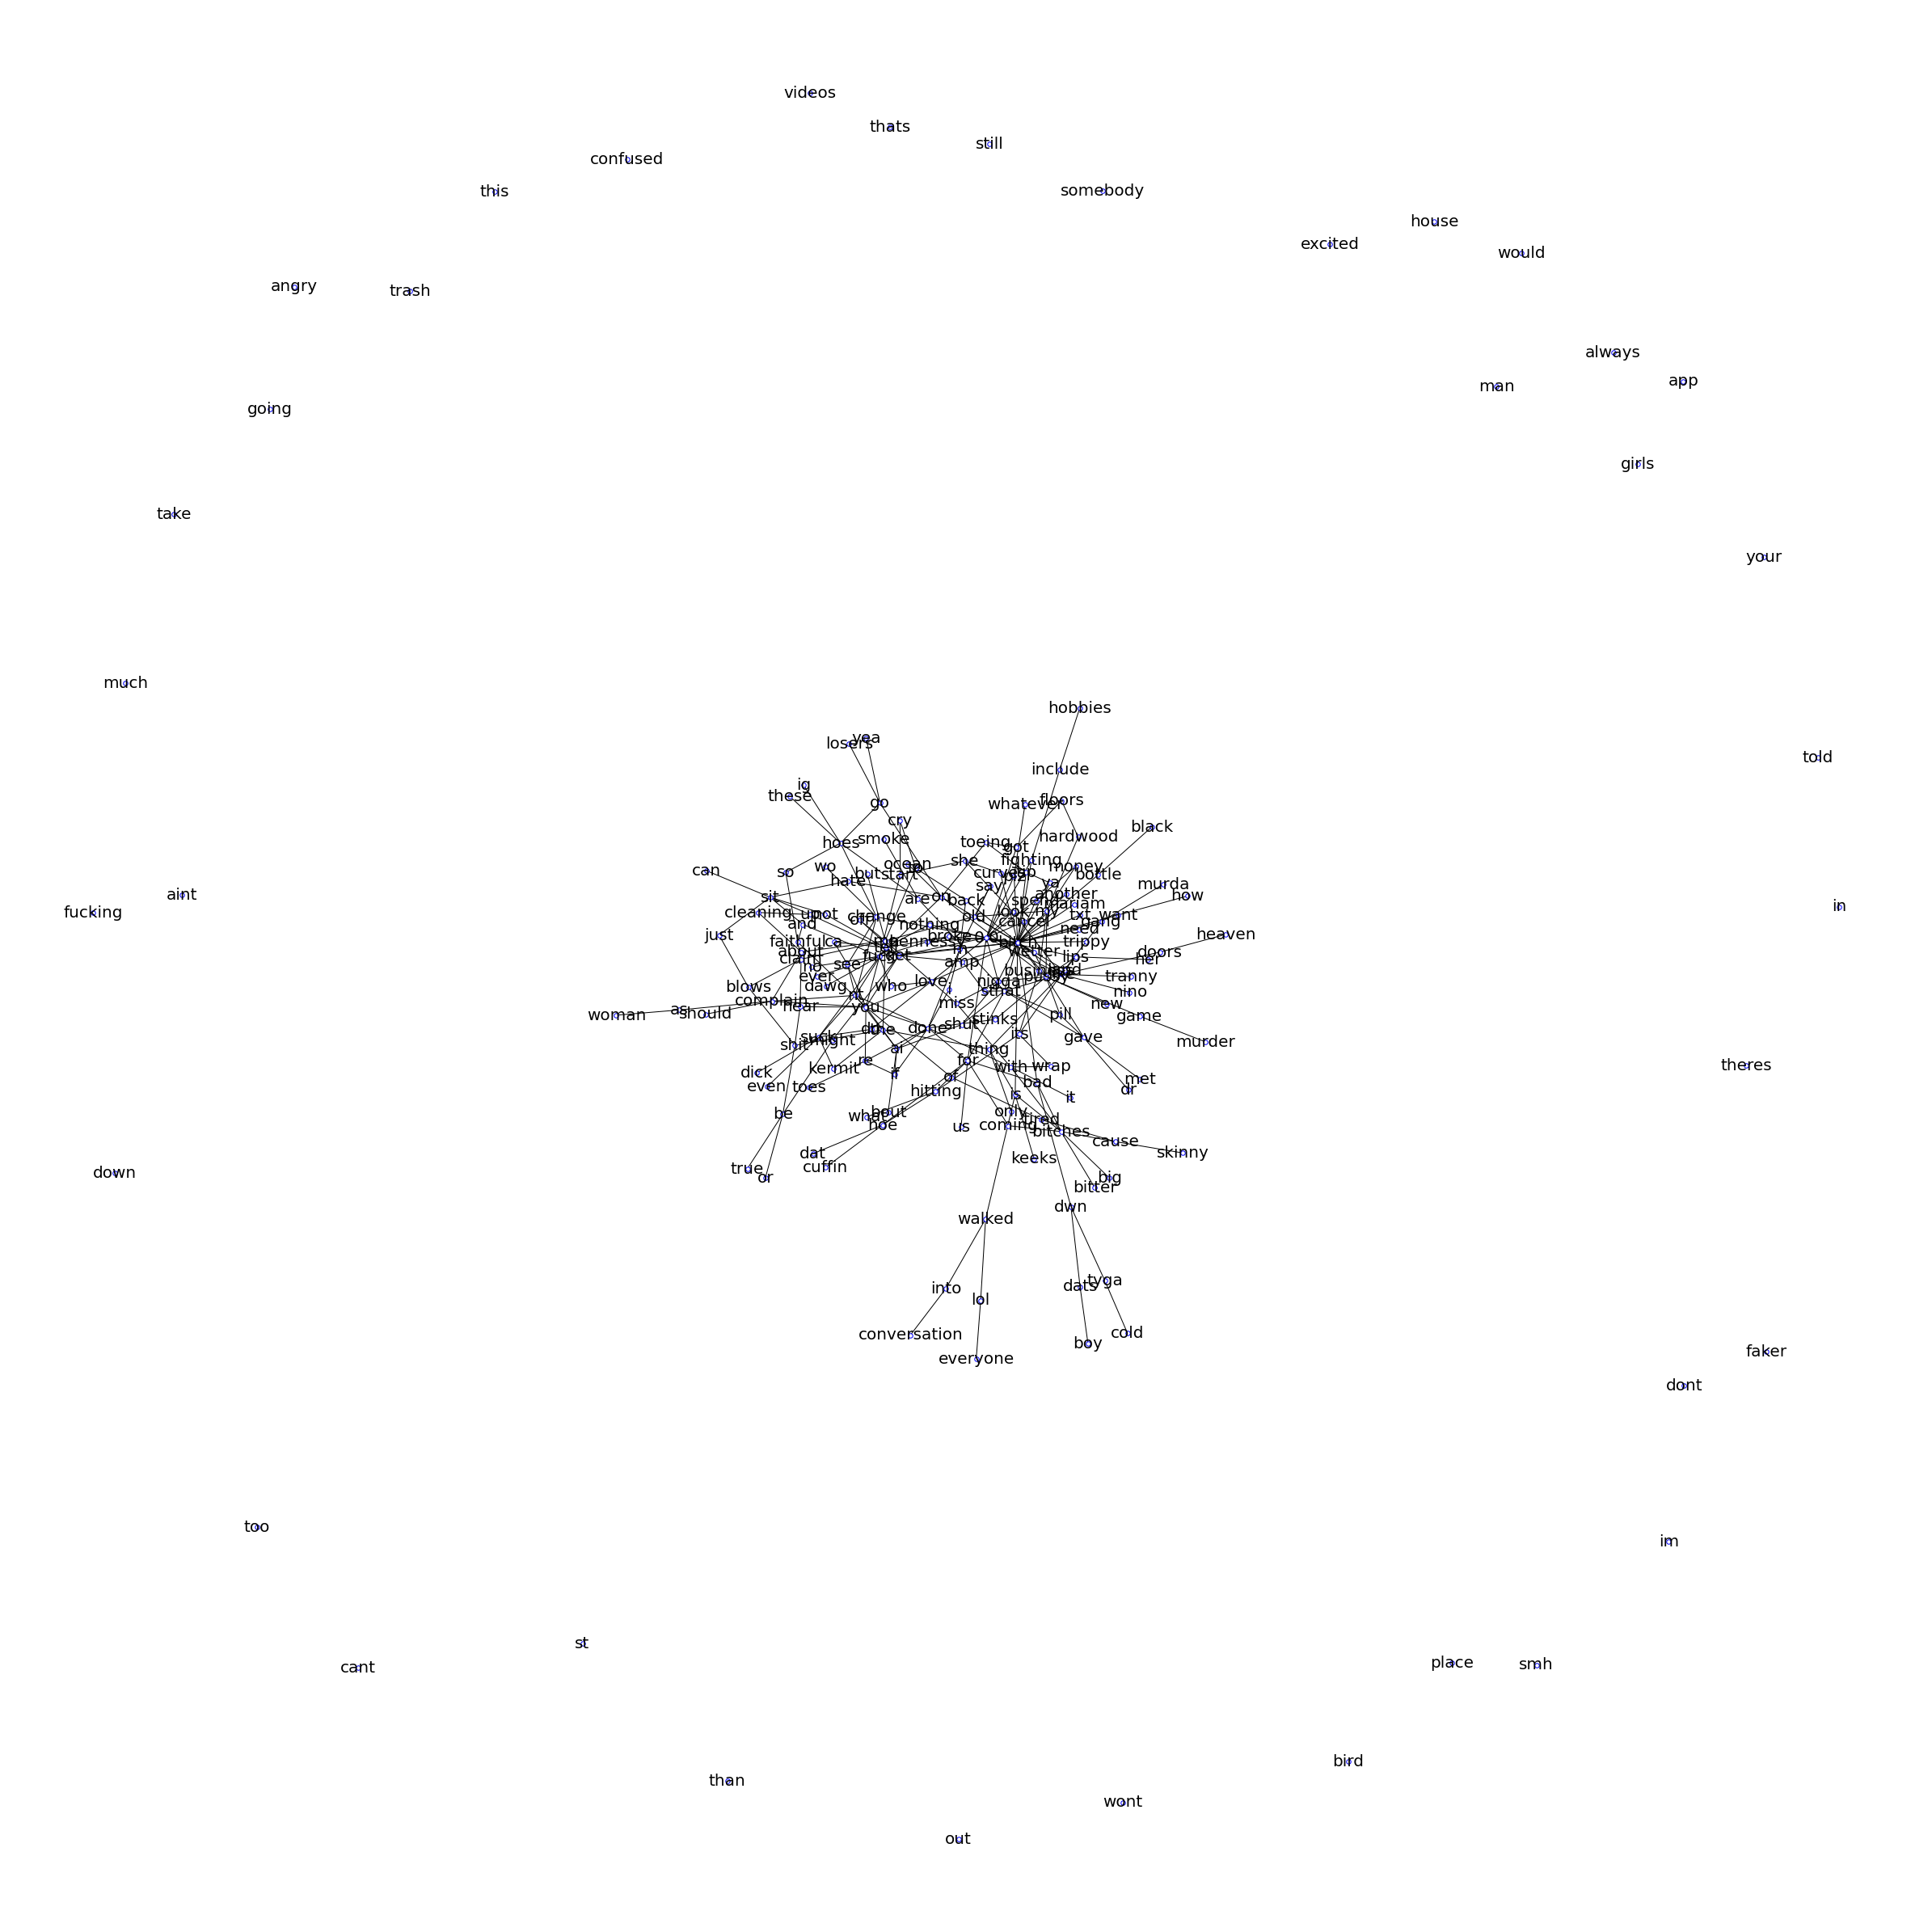

In [79]:
options = {
    "font_size": 20,
    "node_size": 30,
    "node_color": "white",
    "edgecolors": 'blue',
    "linewidths": 1,
    "width": 1,
}
plt.figure(3,figsize=(33,33))
nx.draw(sentence_graph, with_labels=True, **options)

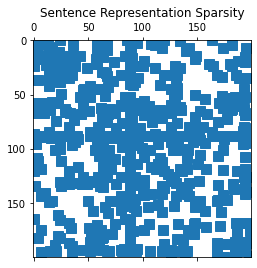

In [208]:
%matplotlib inline
plt.spy(sentence_representation)
plt.title("Sentence Representation Sparsity");

### CLASSIFICATION

#### Classification using Bag-of-Words:

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

In [214]:
x = bow
y = df['class'].astype(int)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
logr = LogisticRegression()
logr.fit(x_train, y_train)
bow_predictions = logr.predict(x_test)
print(bow_predictions)

[1 1 1 1 1 1 1 1 1]


In [37]:
bow_report = classification_report(y_test, bow_predictions)
print(bow_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



#### Classification using embeddings:

In [38]:
v_train, v_test, y_train, y_test = train_test_split(v_average, y, test_size=0.25, random_state=0)
logr.fit(v_train, y_train)
emb_predictions = logr.predict(v_test)
print(emb_predictions)

[1 1 1 1 1 1 1 1 1]


In [39]:
emb_report = classification_report(y_test, emb_predictions)
print(emb_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



#### Classification using both Bag-of-Words and embeddings: 

In [220]:
conc = np.concatenate([bow, v_average], axis=1)

In [221]:
c_train, c_test, y_train, y_test = train_test_split(conc, y, test_size=0.25, random_state=0)
logr.fit(c_train, y_train)
bow_emb_predictions = logr.predict(c_test)
print(bow_emb_predictions)

[1 1 1 1 1 1 1 1 1]


In [222]:
bow_emb_report = classification_report(y_test, bow_emb_predictions)
print(bow_emb_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



#### Classification using syntax

In [226]:
g_train, g_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state=0)
logr.fit(g_train, y_train) 
syntax_predictions = logr.predict(g_test)
print(syntax_predictions)

[1 1 1 1 1 1 1 1 1]


In [227]:
syntax_report = classification_report(y_test, syntax_predictions)
print(syntax_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



In [228]:
# if laptop dies, use some dimensionality reduction method (eg PCA)